<a href="https://colab.research.google.com/github/ywang1110/Modeling_Triboelectric_Performance/blob/main/Humidity___get_optimal_parameters_SEBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from sklearn.feature_selection import f_regression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Prepare dataset

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel('drive/My Drive/1 Manuscript_AFM/Data process/3 NewData_Train - updateDiameter-Validiate.xlsx', sheet_name='mean')
df.head()

,Unnamed: 0,ChargeDensity(µC/m2) j,Thickness (um) x,solidity y,diameter (um) z,Interface (mm) u,Tem (°C),Humidity (%),Force (N),Technique
0,K-1,26.43,472.4,0.164,9.09225,1.728,26.4,25.9,35.5,Reicofil
1,K-2,28.35,568.1,0.180,9.30286,1.961,25.7,27.5,37.1,Reicofil
2,K-3,31.15,472.9,0.181,7.73240,1.501,26.9,28.5,36.1,Reicofil
3,K-4,30.28,600.2,0.179,7.77859,1.990,25.8,29.6,37.3,Reicofil
4,K-5,33.76,393.3,0.206,7.41502,1.106,26.9,28.5,36.1,Reicofil


In [ ]:
df.shape

(43, 10)

## Unit conversion

In [ ]:
data = pd.DataFrame()
data['ChargeDensity(C/m2)']=df['ChargeDensity(µC/m2) j']*pow(10,-6)
data['thickness(m)']=df['Thickness (um) x']*pow(10,-6)
data['solidity'] = df['solidity y']
data['diameter(m)'] = df['diameter (um) z']*pow(10,-6)
data['Interface(m)']=df['Interface  (mm) u']*pow(10, -3)
data['Technique'] = df['Technique']
data[['Tem (°C)', 'Humidity (%)', 'Force (N)']]=df[['Tem (°C)', 'Humidity (%)', 'Force (N)']]

data.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1


In [ ]:
data.shape

(43, 9)

# Train test split

In [ ]:
random_state=76
kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
train_indexs = []
test_indexs = []
for train_index, test_index in kf.split(data):
    train_indexs.append(train_index)
    test_indexs.append(test_index)
index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
index

,train_index,test_index
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 13, 15, 16...","[9, 10, 14, 22, 24, 25, 35, 36, 39]"
1,"[0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 1...","[4, 6, 21, 23, 27, 30, 31, 32, 40]"
2,"[0, 1, 4, 5, 6, 7, 8, 9, 10, 12, 14, 15, 16, 1...","[2, 3, 11, 13, 17, 19, 29, 38, 42]"
3,"[0, 1, 2, 3, 4, 6, 7, 9, 10, 11, 13, 14, 15, 1...","[5, 8, 12, 16, 18, 20, 28, 37]"
4,"[2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 16, ...","[0, 1, 7, 15, 26, 33, 34, 41]"


In [ ]:
n_fold=4

In [ ]:
train_index = index.iloc[n_fold,0]
test_index = index.iloc[n_fold,1]
train, test = data.iloc[train_index], data.iloc[test_index]
train.shape

(35, 9)

In [ ]:
train.shape

(35, 9)

In [ ]:
test.shape

(8, 9)

In [ ]:
"""
train.to_csv('train.csv')
test.to_csv('test.csv')
"""


"\ntrain.to_csv('train.csv')\ntest.to_csv('test.csv')\n"

In [ ]:
"""
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
"""

"\ntrain = pd.read_csv('train.csv')\ntest=pd.read_csv('test.csv')\n"

In [ ]:
# Train the model
x=train['thickness(m)'].to_numpy()
y=train['solidity'].to_numpy()
z=train['diameter(m)'].to_numpy()
u=train['Interface(m)'].to_numpy()
j=train['ChargeDensity(C/m2)'].to_numpy()
def func(X,a, c, m, n, p):
  x,y,z,u = X
  return a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)
# initial guesses for a,b,c,m,n,p:
p0 = 1E-6 , 1. ,1. , 1. , 1.
# lm
popt_lm,pcov = curve_fit(func,(x,y,z,u),j, method='lm', maxfev = 50000)
y_model_lm = func((x,y,z,u),popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4]) 
MSE_lm = mean_squared_error(j, y_model_lm)
MAE_lm = mean_absolute_error(j, y_model_lm)
lm_result="lm Method | MSE = {:.2E}| MAE = {:.2E}| a = {:.2E}, c = {:.2E},m = {:.2E}, n = {:.2E}, p = {:.2E}".format(MSE_lm,MAE_lm,popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4])
lm_result  

'lm Method | MSE = 2.83E-12| MAE = 1.28E-06| a = 1.31E-05, c = 1.34E+00,m = 1.08E+00, n = 1.08E+00, p = 1.09E+00'

In [ ]:
  # trf & dogbox
       #a          b           c          
  bound=((  0,         0,          0,   0,         0         ), 
       (np.inf,    np.inf,    np.inf, np.inf,    np.inf))
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u),j, p0, bounds = bound, method='trf', maxfev=50000)

  y_model_trf = func((x,y,z,u),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u),j, p0, bounds = bound, method='dogbox', maxfev=50000)
  y_model_dog = func((x,y,z,u),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
      print('trf Method is the best method')
  else:
      print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4])

  # Validate (when trf is best)
  a,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4]

  data_val = pd.concat([train, test])
  data_val.head()
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()


  data_val['Predicted(C/m2)'] = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  data_val['ratio(%)'] = (data_val['Predicted(C/m2)'] -data_val['ChargeDensity(C/m2)'])/data_val['ChargeDensity(C/m2)']*100
  data_val['ChargeDensity(uC/m2)'] = data_val['ChargeDensity(C/m2)']*pow(10,6)
  data_val['Predicted(uC/m2)'] = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)*pow(10,6)
  data_val['ratio_2(%)'] = (data_val['Predicted(uC/m2)']-data_val['ChargeDensity(uC/m2)'])/data_val['ChargeDensity(uC/m2)']*100
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  mape_trf = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_trf_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_trf_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])
  print( "trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4]))
  print( "dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4]))
  print('MAPE= {:.2f}'.format(mape_trf))
  print('Train_MAPE = {:.2f}'.format(mape_trf_train))
  print('test_MAPE = {:.2f}'.format(mape_trf_test))

trf Method is the best method
trf Method | MSE = 2.84E-12| MAE = 1.29E-06| a = 7.33358335345706e-06, c = 0.9637914305754077,m = 1.1659956607310682, n = 1.1689975959596484, p = 1.1765786722620015
dog Method | MSE = 3.29E-11| MAE = 4.63E-06| a = 1.90394647438442e-06, c = 0.49804687499999994,m = 1.000011328877653, n = 1.00001171082407, p = 1.000012464984451
MAPE= 4.79
Train_MAPE = 4.69
test_MAPE = 5.24


In [ ]:
data_afterTheory = data_val.iloc[:, :10]
data_afterTheory.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2)
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1,0.000029
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000030
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000030
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000031
6,0.000019,0.000475,0.153,0.000016,0.001347,Reicofil,26.7,27.8,35.8,0.000019


# Humidity

In [ ]:
data_afterTheory['Residual'] = data_afterTheory['Predicted(C/m2)'] - data_afterTheory['ChargeDensity(C/m2)']
data_afterTheory.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2),Residual
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1,0.000029,-2.215841e-06
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000030,-7.683442e-07
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000030,-3.924111e-06
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000031,-3.521669e-06
6,0.000019,0.000475,0.153,0.000016,0.001347,Reicofil,26.7,27.8,35.8,0.000019,3.720106e-07


## Netural network

## Sklearn linear regression

In [ ]:
from sklearn.linear_model import LinearRegression 

In [ ]:
X = data_afterTheory.loc[:, ['Humidity (%)', 'Force (N)']]
y = data_afterTheory.loc[:, 'Residual']

In [ ]:
X_train = data_afterTheory.loc[:, ['Humidity (%)', 'Force (N)']][:35]
y_train = data_afterTheory.loc[:, 'Residual'][:35]

In [ ]:
reg = LinearRegression(fit_intercept = False).fit(X, y)
reg.score(X, y)

0.21994606367274638

In [ ]:
w, l = reg.coef_
print(w, l)

2.5684588583128055e-07 -2.0801033146758604e-07


In [ ]:
reg.intercept_

0.0

In [ ]:
predictedResidual = reg.predict(X)

In [ ]:
data_afterTheory['linear_predictedResidual'] = predictedResidual

In [ ]:
data_afterTheory.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2),Residual,linear_predictedResidual
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1,0.000029,-2.215841e-06,-1.890652e-07
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000030,-7.683442e-07,-1.561471e-07
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000030,-3.924111e-06,-1.890652e-07
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000031,-3.521669e-06,-1.349939e-06
6,0.000019,0.000475,0.153,0.000016,0.001347,Reicofil,26.7,27.8,35.8,0.000019,3.720106e-07,-3.064542e-07


In [ ]:
a, c, m, n, p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4]

In [ ]:
x=data_afterTheory['thickness(m)'].to_numpy()
y=data_afterTheory['solidity'].to_numpy()
z=data_afterTheory['diameter(m)'].to_numpy()
u=data_afterTheory['Interface(m)'].to_numpy()
j=data_afterTheory['ChargeDensity(C/m2)'].to_numpy()

In [ ]:
h = data_afterTheory['Humidity (%)']
f = data_afterTheory['Force (N)']

In [ ]:
data_afterTheory['newPredictedCharge'] = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)-(w*h+l*f)
data_afterTheory.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2),Residual,linear_predictedResidual,newPredictedCharge
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1,0.000029,-2.215841e-06,-1.890652e-07,0.000029
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000030,-7.683442e-07,-1.561471e-07,0.000030
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000030,-3.924111e-06,-1.890652e-07,0.000030
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000031,-3.521669e-06,-1.349939e-06,0.000032
6,0.000019,0.000475,0.153,0.000016,0.001347,Reicofil,26.7,27.8,35.8,0.000019,3.720106e-07,-3.064542e-07,0.000019


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_trf = mean_absolute_percentage_error(data_afterTheory['ChargeDensity(C/m2)'], data_afterTheory['Predicted(C/m2)'])
mape_trf_train = mean_absolute_percentage_error(data_afterTheory['ChargeDensity(C/m2)'][0:train.shape[0]], data_afterTheory['Predicted(C/m2)'][0:train.shape[0]])
mape_trf_test = mean_absolute_percentage_error(data_afterTheory['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_afterTheory['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])

print('MAPE= {:.2f}'.format(mape_trf))
print('Train_MAPE = {:.2f}'.format(mape_trf_train))
print('test_MAPE = {:.2f}'.format(mape_trf_test))

MAPE= 4.79
Train_MAPE = 4.69
test_MAPE = 5.24


In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_trf = mean_absolute_percentage_error(data_afterTheory['ChargeDensity(C/m2)'], data_afterTheory['newPredictedCharge'])
mape_trf_train = mean_absolute_percentage_error(data_afterTheory['ChargeDensity(C/m2)'][0:train.shape[0]], data_afterTheory['newPredictedCharge'][0:train.shape[0]])
mape_trf_test = mean_absolute_percentage_error(data_afterTheory['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_afterTheory['newPredictedCharge'][train.shape[0]:data_val.shape[0]])

print('MAPE= {:.2f}'.format(mape_trf))
print('Train_MAPE = {:.2f}'.format(mape_trf_train))
print('test_MAPE = {:.2f}'.format(mape_trf_test))

MAPE= 4.57
Train_MAPE = 4.81
test_MAPE = 3.55


# Validation at different random seeds

In [ ]:
def get_index(random_state, data):
  kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
  train_indexs = []
  test_indexs = []
  for train_index, test_index in kf.split(data):
      train_indexs.append(train_index)
      test_indexs.append(test_index)
  index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
  return index

In [ ]:
get_index(76, train)

,train_index,test_index
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 15, 16, 17...","[9, 11, 13, 14, 21, 24, 32]"
1,"[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14...","[6, 17, 19, 20, 22, 23, 27]"
2,"[0, 1, 2, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[3, 4, 5, 16, 25, 29, 30]"
3,"[0, 1, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 1...","[2, 8, 12, 18, 28, 31, 34]"
4,"[2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17, ...","[0, 1, 7, 10, 15, 26, 33]"


In [ ]:
a,c,m,n,p, -w, -l

(7.33358335345706e-06,
 0.9637914305754077,
 1.1659956607310682,
 1.1689975959596484,
 1.1765786722620015,
 -2.5684588583128055e-07,
 2.0801033146758604e-07)

In [ ]:
def get_scores(n_fold, index, data):
  train_index = index.iloc[n_fold,0]
  test_index = index.iloc[n_fold,1]
  train, test = data.iloc[train_index], data.iloc[test_index]
  train_shape=train.shape
  test_shape=test.shape

  # Train the model
  x=train['thickness(m)'].to_numpy()
  y=train['solidity'].to_numpy()
  z=train['diameter(m)'].to_numpy()
  u=train['Interface(m)'].to_numpy()
  j=train['ChargeDensity(C/m2)'].to_numpy()
  def func(X,a, c, m, n, p):
    x,y,z,u = X
    return a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)
  # initial guesses for a,b,c,m,n,p:
  p0 = 1E-6 , 1. ,1. , 1. , 1.
  # lm
  popt_lm,pcov = curve_fit(func,(x,y,z,u),j, method='lm', maxfev = 50000)
  y_model_lm = func((x,y,z,u),popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4]) 
  MSE_lm = mean_squared_error(j, y_model_lm)
  MAE_lm = mean_absolute_error(j, y_model_lm)
  lm_result="lm Method | MSE = {:.2E}| MAE = {:.2E}| a = {:.2E}, c = {:.2E},m = {:.2E}, n = {:.2E}, p = {:.2E}".format(MSE_lm,MAE_lm,popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4])
  

  # trf & dogbox
       #a          b           c          
  bound=((  0,         0,          0,   0,         0         ), 
       (np.inf,    np.inf,    np.inf, np.inf,    np.inf))
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u),j, p0, bounds = bound, method='trf', maxfev=50000)

  y_model_trf = func((x,y,z,u),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u),j, p0, bounds = bound, method='dogbox', maxfev=50000)
  y_model_dog = func((x,y,z,u),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
      print('trf Method is the best method')
  else:
      print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4])

  # Validate (when trf is best)
  a,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4]
  data_val = pd.concat([train, test])
  data_val.head()
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h= data_val['Humidity (%)'].to_numpy()
  f= data_val['Force (N)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()


  data_val['Predicted(C/m2)'] = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)
  data_val['newPredicted(C/m2)'] = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)-(w*h+l*f)

  
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  mape_trf = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_trf_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_trf_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])

  mape_trf_new = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['newPredicted(C/m2)'])
  mape_trf_train_new = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['newPredicted(C/m2)'][0:train.shape[0]])
  mape_trf_test_new = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['newPredicted(C/m2)'][train.shape[0]:data_val.shape[0]])
  return n_fold, train_shape, test_shape, mape_trf, mape_trf_train, mape_trf_test, mape_trf_new, mape_trf_train_new, mape_trf_test_new

In [ ]:
max_random_sate = 100

In [ ]:
random_states = []
n_folds = []
train_shapes = []
test_shapes = []
MAPEs = []
train_MAPEs = []
test_MAPEs = []

MAPEs_new = []
MAPEs_train_new = []
MAPEs_test_new = []


for random_state in range(max_random_sate):
  index = get_index(random_state, data)
  for n_fold in range(5):
    random_states.append(random_state)
    n_fold, train_shape, test_shape, MAPE, train_MAPE, test_MAPE,  mape_new,  mape_train_new, mape_test_new = get_scores(n_fold, index, data)
    # n_fold, train_shape, test_shape, MAPE, train_MAPE, test_MAPE = get_scores(n_fold, index, data)
    n_folds.append(n_fold)
    train_shapes.append(train_shape)
    test_shapes.append(test_shape)
    MAPEs.append(MAPE)
    train_MAPEs.append(train_MAPE)
    test_MAPEs.append(test_MAPE)
    
    MAPEs_new.append(mape_new)
    MAPEs_train_new.append(mape_train_new)
    MAPEs_test_new.append(mape_test_new)


trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
dogbox Method is the best method
dogbox Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf 

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
dogbox Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
dogbox Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf 

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
dogbox Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Met

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method

In [ ]:
summary = pd.DataFrame()
summary['random_state']=random_states
summary['n_fold']=n_folds
summary['train_shape'] = train_shapes
summary['test_shape'] = test_shapes

summary['MAPE'] = MAPEs
summary['train_MAPE'] = train_MAPEs
summary['test_MAPE'] = test_MAPEs

summary['MAPE_new'] = MAPEs_new
summary['train_MAPE_new'] = MAPEs_train_new
summary['test_MAPE_new'] = MAPEs_test_new
summary

,random_state,n_fold,train_shape,test_shape,MAPE,train_MAPE,test_MAPE,MAPE_new,train_MAPE_new,test_MAPE_new
0,0,0,"(34, 9)","(9, 9)",4.732114,4.563100,5.370610,5.226030,4.832152,6.714015
1,0,1,"(34, 9)","(9, 9)",5.021760,4.527879,6.887532,4.847623,4.728200,5.298777
2,0,2,"(34, 9)","(9, 9)",4.615092,4.749588,4.106998,4.809885,4.792771,4.874538
3,0,3,"(35, 9)","(8, 9)",4.690002,5.049301,3.118069,4.906683,5.109267,4.020378
4,0,4,"(35, 9)","(8, 9)",4.825558,4.602903,5.799675,4.747709,4.640278,5.217720
...,...,...,...,...,...,...,...,...,...,...
495,99,0,"(34, 9)","(9, 9)",4.837036,5.096916,3.855267,5.088086,4.991344,5.453556
496,99,1,"(34, 9)","(9, 9)",14.163561,12.706513,19.667963,15.774477,14.111952,22.055128
497,99,2,"(34, 9)","(9, 9)",4.892725,5.082013,4.177637,4.942662,5.004876,4.707633
498,99,3,"(35, 9)","(8, 9)",4.748008,4.205608,7.121011,4.819543,4.515659,6.149034


In [ ]:
summary.to_csv('for_100_random_summary.csv')

In [ ]:
=1

SyntaxError: ignored

In [ ]:
# ideal surface area
data_val['idealSurface'] = 2*x*y/z

In [ ]:
data_val['fusionSurface']=c*y**m*x**n/z**p

In [ ]:
data_val['fusion_ratio']=c*y**m*x**n/z**p/(2*x*y/z)*100

In [ ]:
data_val.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%),idealSurface,fusionSurface,fusion_ratio
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1,0.000029,-7.113453,31.15,28.934159,-7.113453,-0.000271,NaN,NaN
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000030,-2.537464,30.28,29.511656,-2.537464,-0.000119,NaN,NaN
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000030,-11.623553,33.76,29.835889,-11.623553,-0.000416,NaN,NaN
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000031,-10.157683,34.67,31.148331,-10.157683,-0.000497,NaN,NaN
6,0.000019,0.000475,0.153,0.000016,0.001347,Reicofil,26.7,27.8,35.8,0.000019,1.985115,18.74,19.112011,1.985115,0.000023,0.000002,8.002394


In [ ]:
data_val.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%),idealSurface,fusionSurface,fusion_ratio
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1,0.000029,-7.113453,31.15,28.934159,-7.113453,-0.000271,NaN,NaN
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000030,-2.537464,30.28,29.511656,-2.537464,-0.000119,NaN,NaN
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000030,-11.623553,33.76,29.835889,-11.623553,-0.000416,NaN,NaN
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000031,-10.157683,34.67,31.148331,-10.157683,-0.000497,NaN,NaN
6,0.000019,0.000475,0.153,0.000016,0.001347,Reicofil,26.7,27.8,35.8,0.000019,1.985115,18.74,19.112011,1.985115,0.000023,0.000002,8.002394


In [ ]:
data_val['relPermitivity'] = data_val['thickness(m)']/data_val['Interface(m)']

In [ ]:
data_val.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%),idealSurface,fusionSurface,fusion_ratio,relPermitivity
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1,0.000029,-7.113453,31.15,28.934159,-7.113453,-0.000271,NaN,NaN,0.315057
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000030,-2.537464,30.28,29.511656,-2.537464,-0.000119,NaN,NaN,0.301608
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000030,-11.623553,33.76,29.835889,-11.623553,-0.000416,NaN,NaN,0.355606
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000031,-10.157683,34.67,31.148331,-10.157683,-0.000497,NaN,NaN,0.340719
6,0.000019,0.000475,0.153,0.000016,0.001347,Reicofil,26.7,27.8,35.8,0.000019,1.985115,18.74,19.112011,1.985115,0.000023,0.000002,8.002394,0.352784


In [ ]:
data_val['relPermitivity'].describe()

count    43.000000
mean      0.342077
std       0.042397
min       0.259089
25%       0.307883
50%       0.344950
75%       0.369297
max       0.413589
Name: relPermitivity, dtype: float64

In [ ]:
data_val.to_csv('relPermitivity_SEBS.csv')

In [ ]:
data_val.describe()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Tem (°C),Humidity (%),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%),idealSurface,fusionSurface,fusion_ratio,relPermitivity
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,2.200000e+01,22.000000,43.000000
mean,0.000027,0.000506,0.194041,0.000010,0.001508,25.793023,29.886047,36.348837,0.000027,0.814779,27.147558,27.260292,0.814779,0.000010,1.613154e-05,10.109660,0.342077
std,0.000004,0.000074,0.020650,0.000003,0.000335,0.965450,2.940731,0.660942,0.000003,6.610254,3.617479,3.176885,6.610254,0.000182,1.638780e-05,1.913127,0.042397
min,0.000019,0.000355,0.153000,0.000007,0.001019,23.800000,25.600000,35.200000,0.000019,-11.623553,18.740000,19.112011,-11.623553,-0.000497,4.250615e-07,6.512065,0.259089
25%,0.000025,0.000470,0.176500,0.000008,0.001273,24.950000,27.450000,36.100000,0.000025,-3.079737,24.885500,25.146164,-3.079737,-0.000088,3.412361e-06,8.794555,0.307883
50%,0.000028,0.000512,0.196000,0.000009,0.001394,25.800000,29.600000,36.100000,0.000028,0.365210,27.751000,27.669054,0.365210,0.000007,9.641134e-06,10.078384,0.344950
75%,0.000030,0.000564,0.211500,0.000013,0.001738,26.500000,31.500000,36.950000,0.000030,2.397760,29.827000,29.509208,2.397760,0.000093,2.584905e-05,11.752339,0.369297
max,0.000035,0.000623,0.240000,0.000017,0.002327,27.300000,36.700000,38.100000,0.000032,20.160782,34.670000,31.858156,20.160782,0.000430,5.639477e-05,13.104480,0.413589


In [ ]:
data_val.to_csv('SEBS_Fusion_Ratio.csv')

## R-Sqaure

In [ ]:
accuracy_lf = metrics.r2_score(data_val['ChargeDensity(uC/m2)'], data_val['Predicted(uC/m2)'])
print('Mutiple Linear Regression Accuracy: ', accuracy_lf)

Mutiple Linear Regression Accuracy:  0.7661506949045765


## Adjust R-Sqaure

In [ ]:
n=data_val.shape[0]
n

43

In [ ]:
p = 4

In [ ]:
Adj_R2 = 1-(1-accuracy_lf)*(n-1)/(n-p-1)
Adj_R2

0.7415349785787425

## F-test

In [ ]:
independent_X = data_val[['thickness(m)', 'solidity', 'diameter(m)', 'Interface(m)']]
independent_X.head()

,thickness(m),solidity,diameter(m),Interface(m)
2,0.000473,0.181,0.000008,0.001501
3,0.000600,0.179,0.000008,0.001990
4,0.000393,0.206,0.000007,0.001106
5,0.000521,0.213,0.000007,0.001530
6,0.000475,0.153,0.000016,0.001347


In [ ]:
independent_X.shape

(43, 4)

In [ ]:
independent_X[:5]

,thickness(m),solidity,diameter(m),Interface(m)
2,0.000473,0.181,0.000008,0.001501
3,0.000600,0.179,0.000008,0.001990
4,0.000393,0.206,0.000007,0.001106
5,0.000521,0.213,0.000007,0.001530
6,0.000475,0.153,0.000016,0.001347


In [ ]:
depedent_y = data_val['ChargeDensity(C/m2)']

In [ ]:
f_regression(independent_X, depedent_y)


(array([ 0.49377589, 16.77863658, 58.73892315,  0.32784774]),
 array([4.86218614e-01, 1.92864328e-04, 1.93381992e-09, 5.70055965e-01]))

In [ ]:
independent_X = sm.add_constant(independent_X)
mreg = sm.OLS(depedent_y, independent_X).fit()
display(mreg.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ChargeDensity(C/m2)   R-squared:                       0.742
Model:                             OLS   Adj. R-squared:                  0.714
Method:                  Least Squares   F-statistic:                     27.27
Date:                 Fri, 10 Sep 2021   Prob (F-statistic):           1.02e-10
Time:                         14:36:00   Log-Likelihood:                 507.37
No. Observations:                   43   AIC:                            -1005.
Df Residuals:                       38   BIC:                            -995.9
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1.951e-05   6.21e-06      3.142      0.003    6.94e-06    3.21e-05
thickness(m)     0.0232      0.008      2.736      0.009       0.006       0.040
solidity      5.175e-05   2.32e-05      2.229      0.032    4.74e-06    9.87e-05
diameter(m)     -0.9276      0.134     -6.908      0.000      -1.199      -0.656
Interface(m)    -0.0030      0.002     -1.333      0.191      -0.008       0.002
==============================================================================
Omnibus:                        0.462   Durbin-Watson:                   1.028
Prob(Omnibus):                  0.794   Jarque-Bera (JB):                0.046
Skew:                           0.014   Prob(JB):                        0.977
Kurtosis:                       3.157   Cond. No.                     4.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

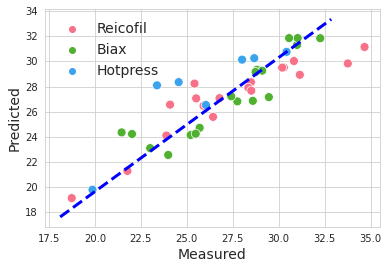

In [ ]:
sns.set_style("whitegrid")
fig, ax = plt.subplots()
sns.scatterplot(data = data_val, x='ChargeDensity(uC/m2)', y='Predicted(uC/m2)', hue='Technique', s=80, palette="husl")

l=data_val['Predicted(uC/m2)']

ax.plot([l.min()-1, l.max()+1], [l.min()-1.5, l.max()+1.5], 'k--', lw=3, color='b')
# ax.plot([17.5, 17.5], [37, 37],'k--', lw=3, color='b')
ax.set_xlabel('Measured', fontsize=14)
ax.set_ylabel('Predicted', fontsize=14)
plt.legend(frameon=False, fontsize=14)
plt.savefig('model with Contact.tiff', dpi=600)
plt.show()

In [ ]:
train_or_test=['train']*35+['test']*8

In [ ]:
pred_plot = data_val[['Technique', 'ChargeDensity(uC/m2)', 'Predicted(uC/m2)', 'ratio(%)', 'Tem (°C)', 'Humidity (%)', 'Force (N)']]
pred_plot['train_or_test'] = train_or_test
pred_plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Technique,ChargeDensity(uC/m2),Predicted(uC/m2),ratio(%),Tem (°C),Humidity (%),Force (N),train_or_test
2,Reicofil,31.150,28.934159,-7.113453,26.9,28.5,36.1,train
3,Reicofil,30.280,29.511656,-2.537464,25.8,29.6,37.3,train
4,Reicofil,33.760,29.835889,-11.623553,26.9,28.5,36.1,train
5,Reicofil,34.670,31.148331,-10.157683,26.9,25.6,38.1,train
6,Reicofil,18.740,19.112011,1.985115,26.7,27.8,35.8,train
8,Reicofil,23.890,24.095229,0.859060,26.9,25.9,36.4,train
9,Reicofil,24.090,26.556440,10.238441,25.8,28.7,37.3,train
10,Reicofil,25.510,27.054626,6.054984,27.0,26.2,36.1,train
11,Reicofil,25.420,28.233702,11.068852,26.5,31.4,37.3,train
12,Reicofil,25.910,26.462725,2.133248,27.2,26.9,36.1,train


In [ ]:
pred_plot.to_csv('pred_plot.csv')

In [ ]:
test

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1
7,0.000022,0.000623,0.162,0.000016,0.002016,Reicofil,26.4,33.0,37.1
15,0.000029,0.000607,0.171,0.000009,0.002217,Reicofil,26.1,26.3,37.3
26,0.000029,0.000500,0.215,0.000010,0.001394,Biax,25.5,30.5,36.1
33,0.000023,0.000561,0.176,0.000014,0.001748,Biax,24.8,30.4,36.1
34,0.000022,0.000610,0.177,0.000014,0.001748,Biax,24.7,31.2,36.1
41,0.000023,0.000414,0.210,0.000009,0.001278,Hotpress,23.9,36.7,36.1


In [ ]:
pred_plot.to_csv('pred_plot.csv')

In [ ]:
df = pd.read_excel('3 NewData_Train - updateDiameter-Validiate.xlsx', sheet_name='mean', index_col=0)
df.head()

FileNotFoundError: ignored

In [ ]:
data = pd.DataFrame()
data['ChargeDensity(C/m2)']=df['ChargeDensity(µC/m2) j']*pow(10,-6)
data['thickness(m)']=df['Thickness (um) x']*pow(10,-6)
data['solidity'] = df['solidity y']
data['diameter(m)'] = df['diameter (um) z']*pow(10,-6)
data['Interface(m)']=df['Interface  (mm) u']*pow(10, -3)
data['Technique'] = df['Technique']
whole=data
whole.head()

In [ ]:
avg_thickness = data['thickness(m)'].mean()
avg_solidity = data['solidity'].mean()
avg_diameter = data['diameter(m)'].mean()
avg_u = data['Interface(m)'].mean()


print('avg_thickness = {:.2f}\navg_solidity = {:.3f}\navg_diameter = {:.2f} '.format(avg_thickness, avg_solidity, avg_diameter))
print('avg_u = {:.3f}'.format(avg_u))
print('thickness | {:.2f}-{:.2f} um'.format(data['thickness(m)'].min()*1E6, data['thickness(m)'].max()*1E6))
print('solidity | {:.2f}-{:.2f}'.format(data['solidity'].min(), data['solidity'].max()))
print('diameter | {:.2f}-{:.2f} um'.format(data['diameter(m)'].min()*1E6, data['diameter(m)'].max()*1E6))

In [ ]:
whole.loc['K-1']

NameError: ignored

In [ ]:
set_thickness = data.loc['K-1']['thickness(m)']
set_solidity = data.loc['K-1']['solidity']
set_diameter = data.loc['K-1']['diameter(m)']
set_u = data.loc['K-1']['Interface(m)']
print('set_thickness = {:.3E}\nset_solidity = {:.3f}\nset_diameter = {:.2E} \nset_u= {:.3f}'.format(set_thickness, set_solidity, set_diameter, set_u))

set_j = data.loc['K-1']['ChargeDensity(C/m2)']
print('measured j= {:.2E}'.format(set_j))

In [ ]:
simulation_df = pd.DataFrame()

In [ ]:
#-----------------------------------------------------------------------------------------------
# Thickness ~ charge
x = np.linspace(100, 1200)*pow(10,-6)
y = set_solidity
z = set_diameter
u = set_u

J = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[0].plot(x*pow(10,6), J*pow(10,6), linestyle="--", linewidth = 6)
ax[0].scatter(set_thickness*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

simulation_df['thickness (um)']=np.linspace(100, 1200)
simulation_df['charge (uC)_1']=J*pow(10,6)

#-----------------------------------------------------------------------------------------------
# solidity ~ charge

x = set_thickness
y = np.linspace(0.05, 0.7)
z = set_diameter
u = set_u

J = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)


ax[1].plot(y,J*pow(10,6), linestyle="--", linewidth = 6)
ax[1].scatter(set_solidity, set_j*pow(10,6), c='b', marker = '^', s=1000)

simulation_df['solidity']=y
simulation_df['charge (uC)_2']=J*pow(10,6)

    
#-----------------------------------------------------------------------------------------------
# Diameter ~ Charge

x = set_thickness
y = set_solidity
z = np.linspace(3, 20)*pow(10,-6)
u = set_u

J = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[2].plot(z*pow(10,6),J*pow(10,6), linestyle="--", linewidth = 6)
ax[2].scatter(set_diameter*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

simulation_df['diameter (um)']=z*pow(10,6)
simulation_df['charge (uC)_3']=J*pow(10,6)




NameError: ignored

In [ ]:
simulation_df.head()

In [ ]:
simulation_df.to_csv('simulation.csv')

In [ ]:
plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.facecolor'] = 'none'


fig, ax = plt.subplots(1,3, figsize=(8,3.5), sharey=True)


#-----------------------------------------------------------------------------------------------
# Thickness ~ charge
x = np.linspace(100, 1200)*pow(10,-6)
y = set_solidity
z = set_diameter
u = set_u

J = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[0].plot(x*pow(10,6), J*pow(10,6), linestyle="--", linewidth = 6)
ax[0].scatter(set_thickness*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[0].set_xlabel("Thickness \n(um)", fontsize=16)
ax[0].set_ylabel("(uC/m2)", fontsize=16)
ax[0].tick_params(axis = 'x', labelsize=14)
ax[0].tick_params(axis = 'y', labelsize=14)
ax[0].set_ylim(0,40)



#-----------------------------------------------------------------------------------------------
# solidity ~ charge

x = set_thickness
y = np.linspace(0.05, 0.7)
z = set_diameter
u = set_u

J = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)


ax[1].plot(y,J*pow(10,6), linestyle="--", linewidth = 6)
ax[1].scatter(set_solidity, set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[1].set_xlabel("solidity", fontsize=16)

ax[1].tick_params(axis = 'x', labelsize=14)
ax[1].tick_params(axis = 'y', labelsize=14)

    
#-----------------------------------------------------------------------------------------------
# Diameter ~ Charge

x = set_thickness
y = set_solidity
z = np.linspace(3, 20)*pow(10,-6)
u = set_u

J = a*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

ax[2].plot(z*pow(10,6),J*pow(10,6), linestyle="--", linewidth = 6)
ax[2].scatter(set_diameter*pow(10,6), set_j*pow(10,6), c='b', marker = '^', s=1000)

ax[2].set_xlabel("diameter\n (um)", fontsize=16)




ax[2].tick_params(axis = 'x', labelsize=14)
ax[2].tick_params(axis = 'y', labelsize=14)

plt.savefig('Simulation.TIFF', dpi=600, transparent=True)